# Store Item Demand Forecasting

+ Dataframe: 5 years of store-item sales data.
+ Goal: predict 12 months of sales for 50 different items at 10 different stores.


In [8]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from math import sqrt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error as mse, mean_absolute_error as mae
from scipy.stats import boxcox
from scipy import stats as scs
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from tbats import TBATS
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999


## Data input

In [9]:
df_all = pd.read_csv('../data/train.csv', parse_dates=['date'], index_col=['date'])

## EDA

In [10]:
df_all.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [11]:
round(df_all.describe())

,store,item,sales
count,913000.0,913000.0,913000.0
mean,6.0,26.0,52.0
std,3.0,14.0,29.0
min,1.0,1.0,0.0
25%,3.0,13.0,30.0
50%,6.0,26.0,47.0
75%,8.0,38.0,70.0
max,10.0,50.0,231.0


In [13]:
missing_values=round(df_all.isna().sum()/len(df_all),4)*100
missing_values

store    0.0
item     0.0
sales    0.0
dtype: float64

In [14]:
sales_per_store = df_all.groupby(["store"]).agg({"sales": ["sum" , np.mean, "min", "max"]})
round(sales_per_store)

sales               
           sum  mean min  max
store                        
1      4315603  47.0   1  155
2      6120128  67.0   3  231
3      5435144  60.0   3  196
4      5012639  55.0   4  186
5      3631016  40.0   2  130
6      3627670  40.0   0  134
7      3320009  36.0   1  122
8      5856169  64.0   4  204
9      5025976  55.0   4  195
10     5360158  59.0   3  187

In [15]:
df_all

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


Text(0.5, 1.0, 'Sales evolution')

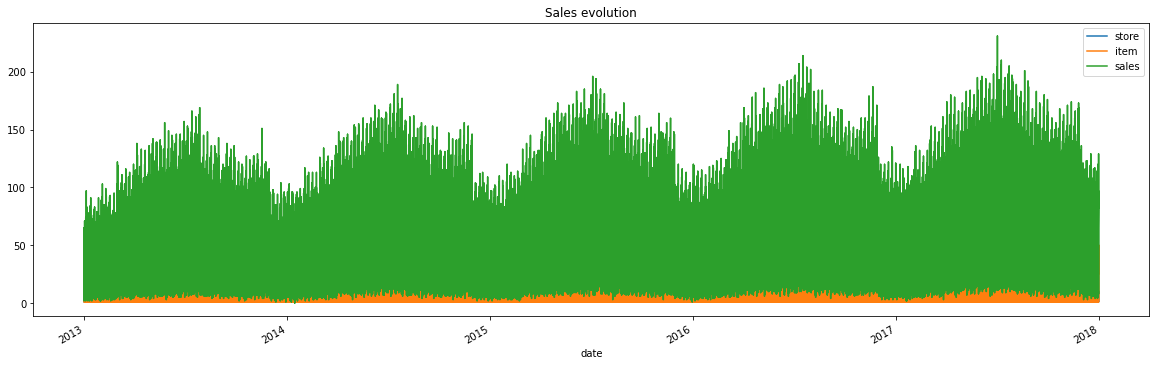

In [17]:
df_all.plot(kind='line', figsize=(20, 6))
plt.title("Sales evolution")

## Filter the data for computational efficiency 

In [18]:
df = df_all[(df_all['store'] == 1) & (df_all['item'] == 1)] # item 1 in store 1
y = df['sales'] # Target variable

<AxesSubplot:xlabel='date'>

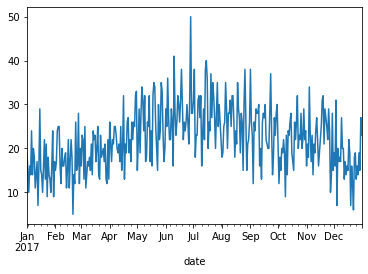

In [20]:
# Check sales evolution in a given year

yearly_sales = df['2017-01':'2017-12']['sales']
yearly_sales.plot()

<AxesSubplot:xlabel='date'>

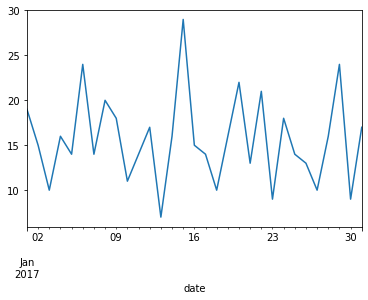

In [21]:
# Check sales evolution in a specific month

monthly_sales = df['2017-01-01':'2017-01-31']['sales']
monthly_sales.plot()

In [ ]:
by_weekly_sales = df['2017-01-15':'2017-01-31']['sales']

## Checking Stationarity

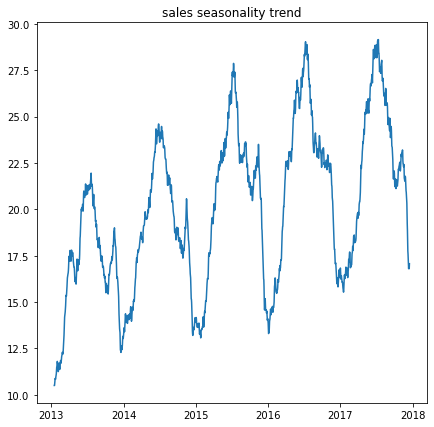

In [22]:
seasonality = sm.tsa.seasonal_decompose(df.sales, model='additive', period=30)
plt.figure(figsize=(7,7))
plt.title("sales seasonality trend")
plt.plot(seasonality.trend)

Text(0.5, 1.0, 'seasonality residuals')

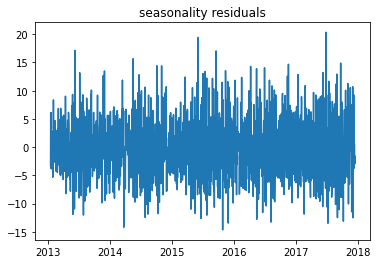

In [23]:
plt.plot(seasonality.resid)
plt.title("seasonality residuals")

In [24]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(df['sales'])

In [25]:
# Find out whether the data is stationary or not
#Ho: It is non-stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
adfuller_test(df['sales'])

ADF Test Statistic : -3.1576705563327883
p-value : 0.02256938062657253
#Lags Used : 23
Number of Observations : 1802
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

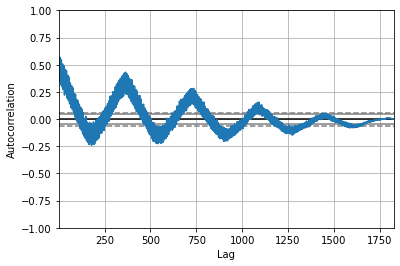

In [26]:
#Autocorrelation plot from pandas ploting.The horizontal lines in the plot correspond to 95% and 99% confidence bands.

autocorrelation_plot(df['sales'])


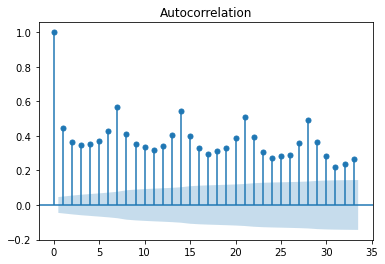

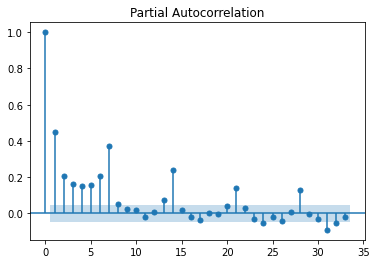

In [27]:
# ACF from stats lib
sm.graphics.tsa.plot_acf(df['sales'].squeeze())
sm.graphics.tsa.plot_pacf(df['sales'])
plt.show()

#The autocorrelation with lag 0 = 1, because this represents the autocorrelation between each term and itself. Sales and sales with lag zero are the same variable.
#Each spike that rises above or falls below the dashed lines is considered to be statistically significant. 
#This means the spike has a value that is significantly different from zero. 
#If a spike is significantly different from zero, that is evidence of autocorrelation. A spike that's close to zero is evidence against autocorrelation.

## Data Split

In [28]:
df = df_all[(df_all['store'] == 1) & (df_all['item'] == 1)] # item 1 in store 1
y = df['sales']

y_to_train = y.iloc[:(len(y)-365)] # train with data from 2013 to 2016
y_to_test = y.iloc[(len(y)-365):] # testing with data for 2017 (1Y)

## Modelling & Model Evaluation

+ Using TBATS time series forecasting model.

In [29]:
# Create estimator
estimator = TBATS(seasonal_periods=(7, 365), # multi-seasonality sighted per week and year
                  #use_arma_errors=True,  # shall try models with ARMA then true, otherwise false
                  use_box_cox=False)
model = estimator.fit(y_to_train)

In [30]:
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

# Model parameters
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 365.]
Seasonal harmonics [ 3 10]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.019279
Seasonal Parameters (Gamma): [8.85647947e-09 1.48796621e-08 4.22016713e-10 1.00894463e-08]
AR coefficients []
MA coefficients []
Seed vector [16.62499269 -2.63398389 -0.19739079  1.1934355  -0.73625397  1.77350894
  0.93232241 -4.69096314 -0.10670963 -1.07921529 -0.04025267 -0.44997991
 -0.07968306  0.24442315  0.19488494  0.46870176  0.27191939 -0.72220965
 -0.92633979 -0.69902276  0.23533074  0.54067726  0.71978048  0.03573231
  0.23980164 -0.10429639 -0.30075813]

AIC 15013.531628


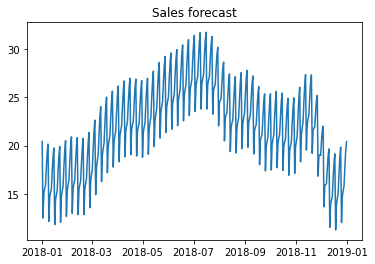

In [31]:
# Convert the numpy array into a pandas series

df_forecast = pd.DataFrame(y_forecast, columns=["forecast"], index=pd.date_range("2018", freq="D", periods=365))
forecast_series = df_forecast.squeeze()
forecast_series.shape
plt.plot(forecast_series)
plt.title("Sales forecast")
plt.show()

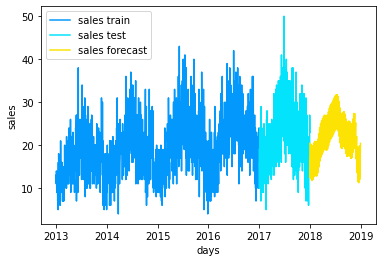

<Figure size 1440x432 with 0 Axes>

In [32]:
# Plot the results

from mpl_toolkits.axes_grid1 import host_subplot
host = host_subplot (1,1,1)
host.set_xlabel("days")
host.set_ylabel("sales")

plt.plot(y_to_train, label= "sales train", color = "#0398fc")
plt.plot(y_to_test, label = "sales test", color='#03e3fc')
plt.plot(forecast_series, label = "sales forecast", color='#fce303')
plt.legend()
plt.figure(figsize=(20,6))
plt.show()

In [33]:
print('FORECAST:\n')
print('Values:', y_forecast[:20]) # 20 days' values
print('MAE:', np.mean(np.abs(y_forecast - y_to_test)))

FORECAST:

Values: [20.42923062 12.47336521 15.05056579 15.54164845 15.90502776 17.74584536
 19.2771722  20.15164287 12.12512266 14.64828742 15.10323156 15.44905533
 17.29099182 18.84162448 19.75255277 11.77810545 14.36697988 14.89892091
 15.33038813 17.26376959]
MAE: 3.8785600320718534


[ 9.72017905 10.32291632 10.74338687 ... 15.78000512 17.82875543
 19.5768557 ]
[ 3.27982095  0.67708368  3.25661313 ...  5.21999488  6.17124457
 -5.5768557 ]


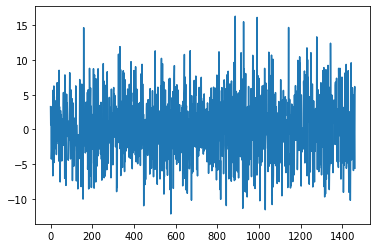

In [34]:
# Model residuals

print(model.y_hat)# in sample prediction
print(model.resid)
plt.plot((model.resid))

+ Using ARIMA from pmdarima

In [35]:
from pmdarima import auto_arima
arima_model = auto_arima(y_to_train, seasonal=True, m=7) 
y_arima_forecast = arima_model.predict(n_periods=365)

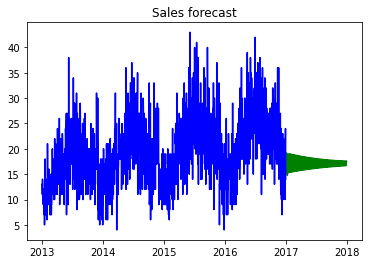

In [36]:
df_arima_forecast = pd.DataFrame(y_arima_forecast, columns=["forecast"], index=pd.date_range("2017", freq="D", periods=365))
arima_forecast_series = df_arima_forecast.squeeze()
arima_forecast_series.shape
plt.plot(arima_forecast_series, c='green')
plt.plot(y_to_train, c='blue')
plt.title("Sales forecast")
plt.show()

+ Using ARIMA from Statsmodel

In [37]:
# Building the ARIMA model
model = ARIMA(df["sales"], order=(7,0,0), trend = "t")
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1826
Model:                 ARIMA(7, 0, 0)   Log Likelihood               -5598.460
Date:                Thu, 16 Dec 2021   AIC                          11214.920
Time:                        11:58:17   BIC                          11264.508
Sample:                    01-01-2013   HQIC                         11233.211
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0159      0.003      5.019      0.000       0.010       0.022
ar.L1          0.1781      0.021      8.463      0.000       0.137       0.219
ar.L2          0.0632      0.022      2.903      0.0